In [8]:
import random
import pandas as pd
from collections import OrderedDict

In [2]:
usda = pd.read_csv('https://raw.githubusercontent.com/jctestud/food-reverse-engineering/master/usda.csv')

In [5]:
# nutritional components we choose to work on
nutritional_components = [
 'protein (g)',
 #'sodium (g)',
 #'fiber (g)',
 'carbohydrate (g)',
 #'sugars (g)',
 'fat (g)',
 'calories',
 #'saturated (g)'
]
usda = usda[nutritional_components].copy()

In [9]:
# nutritional composotion of different food
food_composition = {
    "sugar": usda.iloc[6621],
    "lactose": usda.iloc[6621],
    "dextrose/sugar": usda.iloc[6621],
    "cocoa_butter": usda.iloc[701],
    "palm_oil": usda.iloc[740],
    "emulsifier": usda.iloc[748],
    "hazelnut": usda.iloc[3885],
    "roasted_peanuts": usda.iloc[5318],
    "cocoa": usda.iloc[6451],
    "low_fat_cocoa": usda.iloc[6452],
    "nonfat_milk_powder": usda.iloc[177],
    "salt": usda.iloc[247],
    "milk_fat": pd.Series(OrderedDict([("protein (g)", 6.3), ("sodium (g)", 0.107), ("fiber (g)", 3.), ("carbohydrate (g)", 57.5), ("sugars (g)", 56.3), ("fat (g)", 30.9), ("calories", 539), ("saturated (g)", 10.6), ])),
    "nutella": pd.Series(OrderedDict([("protein (g)", 6.3), ("sodium (g)", 0.107), ("fiber (g)", 3.), ("carbohydrate (g)", 57.5), ("sugars (g)", 56.3), ("fat (g)", 30.9), ("calories", 539), ("saturated (g)", 10.6), ])), # 
    "peanut_butter_cups": pd.Series(OrderedDict([("protein (g)", 9.5), ("sodium (g)", 0.3), ("fiber (g)", 2.4), ("carbohydrate (g)", 54.8), ("sugars (g)", 47.6), ("fat (g)", 31.0), ("calories", 547.6), ("saturated (g)", 10.7)]))
}

In [19]:
# Nutella
ingredients = ["sugar", "palm_oil", "hazelnut", "low_fat_cocoa", "nonfat_milk_powder", "emulsifier"]
ningredients = len(ingredients)
#ingredient_weights = [None]*len(ingredients)
target = "nutella"

In [14]:
## Target
nutella_nutrientprofile = food_composition['nutella'][nutritional_components]

In [30]:
def getProbs(n):
    probs = np.random.dirichlet(np.ones(n),size=1)
    probs = list(probs[0])
    probs.sort(reverse=True)
    return probs

In [24]:
### Random weights
ingredient_weights = getProbs(ningredients) 

In [146]:
### Realistic weights
# https://www.nutella.com/sg/en/products/nutella
realistic_ingredient_weights = [0.5,0.199,0.13, 0.087, 0.074,0.01]
realistic_ingredient_weights = getIngredient(realistic_ingredient_weights)

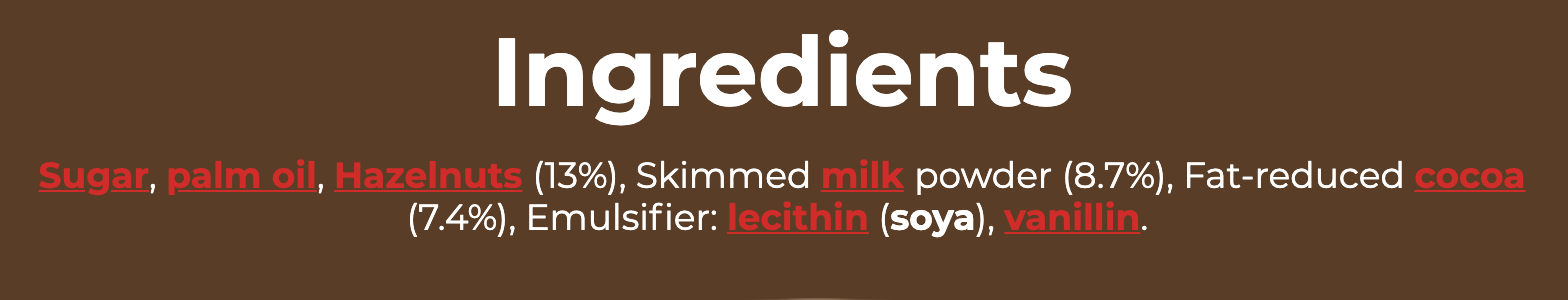

In [242]:
def getIngredientXWeights(ingredient_weights,ingredients=ingredients):
    ingXweight = dict(zip(ingredients,ingredient_weights))
    return ingXweight

In [69]:
def nutritionProfileFromIngredientWeights(ingXweight):
    scaledNutr = dict()
    for k,v in ingXweight.items():
        scaledNutr[k] = food_composition[k][nutritional_components] * v
    predictedNutrProfiles = pd.DataFrame(scaledNutr).sum(1)
    return predictedNutrProfiles

In [71]:
predictedNutrProfiles = nutritionProfileFromIngredientWeights(ingXweight)

In [76]:
### Is the prediction good? sum of square of the differences
def getloss(realNutrProfile,predictedNutrProfile):
    loss = (realNutrProfile-predictedNutrProfile).pow(2).sum() 
    maxloss = realNutrProfile.pow(2).sum()
    return loss, maxloss

In [81]:
loss, maxloss = getloss(nutella_nutrientprofile,predictedNutrProfiles)

In [86]:
loss < maxloss/2 #Is it a good

True

In [99]:
def makePopulation(popsize,ingredients):
    nIngredients = len(ingredients)
    listofweights = [getProbs(nIngredients)  for p in range(popsize)]
    allindividuals = [dict(zip(ingredients,_)) for _ in listofweights]
    return allindividuals

In [249]:
popsize = 10

In [101]:
generation1 = makePopulation(popsize,ingredients)

In [102]:
generation1[0]

{'sugar': 0.4921723856542037,
 'palm_oil': 0.2208572450929852,
 'hazelnut': 0.11379460122575817,
 'low_fat_cocoa': 0.09616831577323956,
 'nonfat_milk_powder': 0.06289381492732116,
 'emulsifier': 0.014113637326492099}

In [142]:
def calcfitness(ingredientWeightsDictionary,realNutrProfile):
    predictedNutrProfiles = nutritionProfileFromIngredientWeights(ingredientWeightsDictionary)
    loss, maxloss = getloss(realNutrProfile,predictedNutrProfiles)
    return predictedNutrProfiles,loss

In [153]:
npRealistic, lossRealistic = calcfitness(realistic_ingredient_weights,nutella_nutrientprofile)
npA, lossA = calcfitness(generation1[0],nutella_nutrientprofile)
npB, lossB = calcfitness(generation1[1],nutella_nutrientprofile)
npC, lossC = calcfitness(generation1[2],nutella_nutrientprofile)
lossA,lossB,lossC,lossRealistic

(599.1491671330284, 1755.7276046752709, 8131.32434555121, 996.6411208903978)

### Tournament

In [155]:
winnerA = generation1[0] if lossA < lossB else generation1[1]
winnerX = realistic_ingredient_weights if lossRealistic < lossC else generation1[2]

In [161]:
winnerA = list(winnerA.values())
winnerX = list(winnerX.values())

In [165]:
brk = int(len(ingredients)/2)
offspring1 = winnerA[:brk] + winnerX[brk:]
offsprign2 = winnerX[:brk] + winnerA[brk:]
offspring1,offspring2 = getIngredient(offspring1), getIngredient(offsprign2)

In [168]:
calcfitness(offspring1,nutella_nutrientprofile),calcfitness(offspring2,nutella_nutrientprofile)

((protein (g)           6.091373
  carbohydrate (g)     60.094000
  fat (g)              31.435388
  calories            513.473830
  dtype: float64,
  658.644341150038),
 (protein (g)           6.113039
  carbohydrate (g)     61.115366
  fat (g)              30.789298
  calories            508.858642
  dtype: float64,
  921.6195256365719))

### To do: implement mutation

### Generalize to the whole first generation

* Calculate fitness for each individual
* Get offspring: Pick for at random, tournament. 
* Repeat until next generation's size is the same as gen0

In [175]:
calcfitness(generation1[0],nutella_nutrientprofile)

(protein (g)           5.869472
 carbohydrate (g)     60.047546
 fat (g)              31.963806
 calories            514.682473
 dtype: float64,
 599.1491671330284)

In [267]:
def populationstats(population,realNutrProfile):
    genStats = []
    for _ in population:
        nutrprof_, loss_ = calcfitness(_,realNutrProfile)
        genStats.append([_,nutrprof_, loss_])
    genStatsDF = pd.DataFrame(genStats,columns=['ingredientXweight','nutrprofile','loss'])
    return genStatsDF

In [268]:
def shuffleTournament(tournamentfour):
    idx = list(tournamentfour.index)
    random.shuffle(idx)
    a,b,c,d = idx
    return a,b,c,d

def getWinner_ingsXweights(tournamentfour,idxA,idxB):
    if tournamentfour.loc[idxA]['loss'] < tournamentfour.loc[idxB]['loss']:
        winner = tournamentfour.loc[idxA]['ingredientXweight'] 
    else:
        winner = tournamentfour.loc[idxB]['ingredientXweight']
    return winner

In [269]:
def tournament(genStatsDF,n=4):
    tournamentDF = genStatsDF.sample(n)
    tournamentfour = tournamentDF.copy()
    ### Shuffle combatants
    a,b,c,d = shuffleTournament(tournamentfour)
    ### First
    winnerA = getWinner_ingsXweights(tournamentfour,a,b)
    ### Second
    winnerX = getWinner_ingsXweights(tournamentfour,c,d)
    return winnerA, winnerX

def recombineWinners(winnerA,winnerX,brk = int(len(ingredients)/2)):
    ###
    winnerA = list(winnerA.values())
    winnerX = list(winnerX.values())
    ###
    offspring1 = winnerA[:brk] + winnerX[brk:]
    offspring2 = winnerX[:brk] + winnerA[brk:]
    ###
    offspring1 = getIngredientXWeights(offspring1)
    offspring2 = getIngredientXWeights(offspring2)
    return offspring1,offspring2

In [270]:
def getNewPopulation(genStatsDF,popsize=popsize):
    newgen = []
    while len(newgen) < popsize:
        winnerA, winnerX = tournament(genStatsDF)
        offA,offB = recombineWinners(winnerA,winnerX)
        ### ToDo: implement mutation
        newgen.append(offA)
        newgen.append(offB)
    return newgen

### Iterate over n generations

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [373]:
def reverseengineer(ingredients,realNutrProfile,popsize = 10,nGens = 100,plotloss=True):
    if popsize < 4:
        print(f'Pop size must be > {popsize}; defaulting to 10')
        popsize = 10
    #### Save values
    popDF = dict()
    avgLoss = dict()
    #####
    foundergeneration = makePopulation(popsize,ingredients)
    #####
    founderStatsDF = populationstats(foundergeneration,realNutrProfile)
    popDF[0] = founderStatsDF
    avgLoss[0] = founderStatsDF.loss.mean()
    #####
    for i in range(1,nGens):
        nextgen = getNewPopulation(popDF[i-1])
        nextGenStatsDF = populationstats(nextgen,nutella_nutrientprofile)
        popDF[i] = nextGenStatsDF
        avgLoss[i] = nextGenStatsDF.loss.mean()
    if plotloss:
        lossDF = pd.DataFrame.from_dict(avgLoss,orient='index').reset_index()
        plt.title(f'loss over {nGens} generations: {round(lossDF[0].min(),2)}')
        sns.lineplot(data=lossDF,x='index',y=0)
        sns.scatterplot(data=lossDF,x='index',y=0)
        plt.ylabel('loss (sum of squared error)')
        plt.xlabel('generation')
        plt.show()
    ###
    bestsolution_ = popDF[i].sort_values('loss',ascending=False).head(1)
    bestsolution_weights = bestsolution_['ingredientXweight'][0]
    bestsolution_profile = bestsolution_['nutrprofile'][0]
    return bestsolution_weights,bestsolution_profile

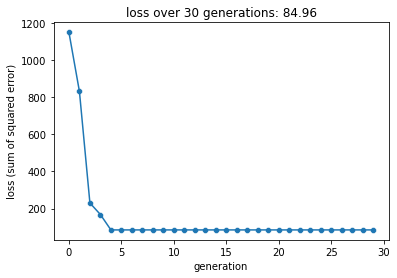

,proportion
sugar,44.01
palm_oil,23.18
hazelnut,13.10
low_fat_cocoa,17.01
nonfat_milk_powder,6.79
emulsifier,2.94


In [415]:
bestsol, bestsolnutrporf = reverseengineer(ingredients,nutella_nutrientprofile,8,30)
bestsolprops = {k:round(v*100,2) for k,v in bestsol.items()}
bestsolprops = pd.DataFrame.from_dict(bestsolprops,orient='index',columns=['proportion'])
bestsolprops

In [416]:
bestsolnutrporf

protein (g)           7.758053
carbohydrate (g)     59.682828
fat (g)              36.682684
calories            545.680360
dtype: float64

In [418]:
nutella_nutrientprofile

protein (g)           6.3
carbohydrate (g)     57.5
fat (g)              30.9
calories            539.0
dtype: float64